In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

load data

In [3]:
n_rois = 68
count_offset = 100
data_path = '../sample_data/'
brain_networks, traits, translations, rotations, avg_trans, avg_rotat = preprocess_neural_data(data_path+'hcp_data.npy')

In [4]:
std_trans = min_max_standardize(avg_trans)
std_rotat = min_max_standardize(avg_rotat)
motion = np.concatenate([std_trans, std_rotat], axis=-1)

In [5]:
with open(data_path+'hcp_traits_dict.txt') as f:
    lines = f.readlines()
f.close()

In [6]:
pic_vocab = traits[:,6]
card_sort = traits[:,42]
oral_reading = traits[:,4]
pattern_complete = traits[:,10]
pic_seq = traits[:,37]

In [7]:
drop_ids = np.isnan(card_sort)
card_sort = card_sort[~drop_ids]
brain_networks = brain_networks[~drop_ids]
motion = motion[~drop_ids]
n_subs = brain_networks.shape[0]

In [8]:
config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    beta = .01, add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=200, lr=1e-5, device=DEVICE)

In [9]:
A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]

In [10]:
ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(oral_reading).to(torch.float32) 

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

956 107


vae

In [11]:
oral_reading_vae = VAE(config).to(config.device)
oral_reading_vae.apply(reset_weights)
oral_reading_vae.set_mask(knn_masks)
optimizer = optim.Adam(oral_reading_vae.parameters(), lr=config.lr) 

In [12]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = oral_reading_vae.reg_train(epoch, train_loader, oral_reading_vae, optimizer, config.device, n_epoch_display=5)
    val_loss = oral_reading_vae.reg_test(epoch, val_loader, oral_reading_vae, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 8100.170 nll: -1682.145 kl: 405.904 rmse: 17.484
epoch: 0 test loss: -393.617 nll: -8383.963 kl: 844.467 rmse: 17.025
epoch: 5 train loss: -16344.915 nll: -16876.482 kl: 14897.510 rmse: 3.443
epoch: 5 test loss: -16189.782 nll: -16764.724 kl: 14868.283 rmse: 3.895
epoch: 10 train loss: -16405.683 nll: -16927.235 kl: 14706.131 rmse: 3.406
epoch: 10 test loss: -16241.737 nll: -16808.749 kl: 14429.262 rmse: 3.880
epoch: 15 train loss: -16426.356 nll: -16939.835 kl: 14418.805 rmse: 3.382
epoch: 15 test loss: -16261.090 nll: -16819.781 kl: 14135.837 rmse: 3.855
epoch: 20 train loss: -16440.048 nll: -16944.815 kl: 14175.697 rmse: 3.354
epoch: 20 test loss: -16274.575 nll: -16824.485 kl: 13882.406 rmse: 3.825
epoch: 25 train loss: -16451.837 nll: -16947.292 kl: 13963.111 rmse: 3.320
epoch: 25 test loss: -16286.466 nll: -16826.797 kl: 13659.214 rmse: 3.790
epoch: 30 train loss: -16463.154 nll: -16948.844 kl: 13787.667 rmse: 3.283
epoch: 30 test loss: -16297.889 nll: -16828

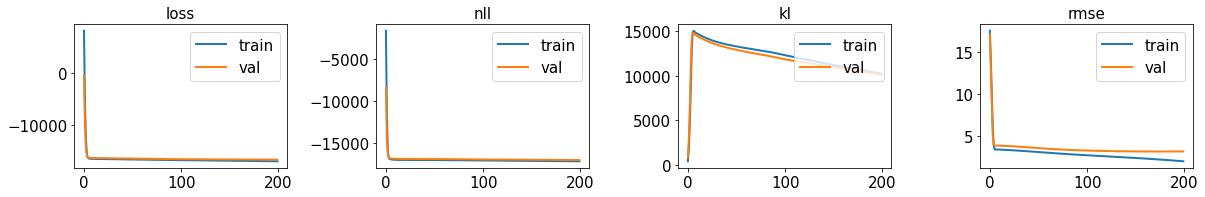

In [13]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(17, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('rmse')
axes[3].legend(loc=1)
plt.tight_layout()
plt.show()

inv_vae

In [14]:
config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0., 
    beta = .01, gamma = .01, add_reg = True, y_dim = 1,
    batch_size=32, n_epochs=200, lr=2e-5, device=DEVICE)

In [15]:
oral_reading_inv = INV_VAE(config).to(config.device)
oral_reading_inv.apply(reset_weights)
oral_reading_inv.set_mask(knn_masks)
optimizer = optim.Adam(oral_reading_inv.parameters(), lr=config.lr) 

In [16]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = oral_reading_inv.reg_train(epoch, train_loader, oral_reading_inv, optimizer, config.device, n_epoch_display=5)
    val_loss = oral_reading_inv.reg_test(epoch, val_loader, oral_reading_inv, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 8484.345 nll: -6869.068 kl: 1049.525 inv_loss: 3.920 rmse: 16.272
epoch: 0 test loss 5170.805 nll: -15108.992 kl: 3168.862 inv_loss: 7.157 rmse: 13.916
epoch: 5 train loss: 205.482 nll: -16922.516 kl: 22482.685 inv_loss: 1.542 rmse: 3.408
epoch: 5 test loss 255.500 nll: -16801.611 kl: 21732.411 inv_loss: 1.472 rmse: 3.872
epoch: 10 train loss: 195.899 nll: -16937.134 kl: 19977.314 inv_loss: 1.732 rmse: 3.365
epoch: 10 test loss 245.383 nll: -16814.394 kl: 19462.095 inv_loss: 1.719 rmse: 3.826
epoch: 15 train loss: 184.086 nll: -16940.674 kl: 19832.944 inv_loss: 1.748 rmse: 3.310
epoch: 15 test loss 232.985 nll: -16818.017 kl: 19248.642 inv_loss: 1.704 rmse: 3.769
epoch: 20 train loss: 170.931 nll: -16941.799 kl: 19871.953 inv_loss: 1.649 rmse: 3.248
epoch: 20 test loss 219.368 nll: -16818.657 kl: 19137.480 inv_loss: 1.629 rmse: 3.704
epoch: 25 train loss: 157.073 nll: -16942.768 kl: 19883.356 inv_loss: 1.517 rmse: 3.181
epoch: 25 test loss 205.490 nll: -16820.423 k

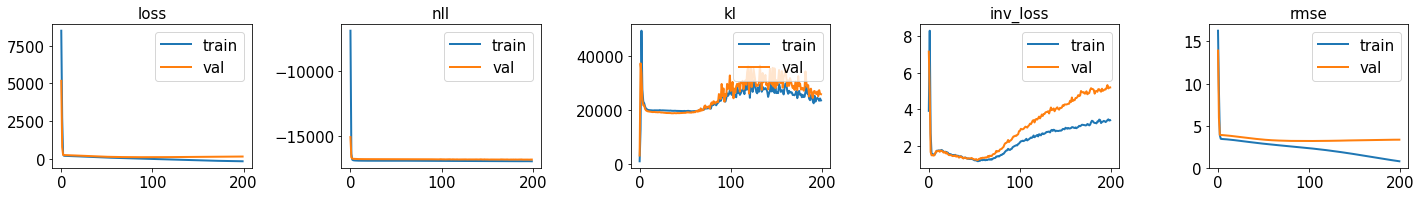

In [17]:
# diagnostics
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)

axes[4].plot(train_losses[:,4], linewidth=2, label='train')
axes[4].plot(val_losses[:,4], linewidth=2, label='val')
axes[4].set_title('rmse')
axes[4].legend(loc=1)

plt.tight_layout()
plt.show()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

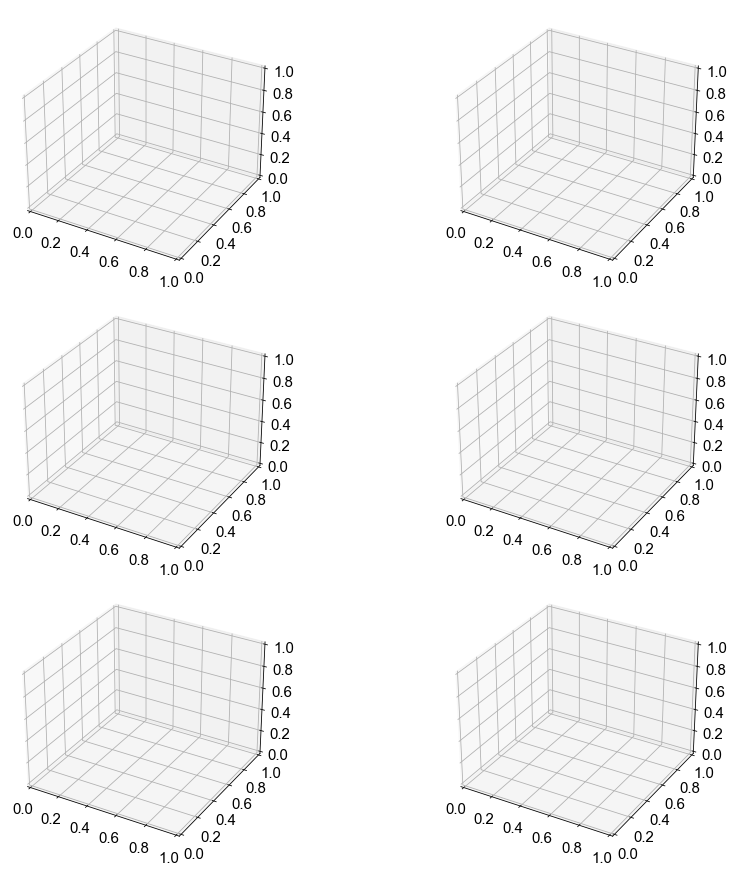

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True, subplot_kw=dict(projection='3d'))
plt.style.use('seaborn-white')

# pic vocab - vae
# pic_vocab_vae_z_mean, _ = pic_vocab_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, pic_vocab_vae_y_pred, _, _ = pic_vocab_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# pic_vocab_vae_y_pred = pic_vocab_vae_y_pred.detach().cpu().numpy()

# pic_vocab_y_ids = np.argsort(pic_vocab)
# pic_vocab_y_sub_ids = np.concatenate([pic_vocab_y_ids[:100], pic_vocab_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# pic_vocab_vae_colors = pic_vocab[pic_vocab_y_sub_ids]

# pic_vocab_vae_z_mean_sub = pic_vocab_vae_z_mean[pic_vocab_y_sub_ids, :].detach().cpu().numpy()
# pca = PCA(n_components=3)
# pca.fit(pic_vocab_vae_z_mean_sub.transpose())
# pic_vocab_vae_pcs = pca.components_.transpose()

# ax1 = fig.add_subplot(321, projection='3d')
# p1 = axes[0,0].scatter(pic_vocab_vae_pcs[:,0], pic_vocab_vae_pcs[:,1], pic_vocab_vae_pcs[:,2], c=pic_vocab_vae_colors, cmap = 'jet', s = 50, vmin=60, vmax=150)
# cb = fig.colorbar(p1, ax=axes[0,0], location='left', fraction=0.02)
# axes[0,0].set_title('GATE')
# axes[0,0].set_xlim3d(min(pic_vocab_vae_pcs[:,0]), max(pic_vocab_vae_pcs[:,0]))
# axes[0,0].set_ylim3d(min(pic_vocab_vae_pcs[:,1]), max(pic_vocab_vae_pcs[:,1]))
# axes[0,0].set_zlim3d(min(pic_vocab_vae_pcs[:,2]), max(pic_vocab_vae_pcs[:,2]))
# axes[0,0].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# axes[0,0].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# axes[0,0].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# pic vocab - inv_vae
# pic_vocab_inv_z_mean, _ = pic_vocab_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, pic_vocab_inv_y_pred, _, _ = pic_vocab_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
#                                              tensor_motion.to(config.device))
# pic_vocab_inv_y_pred = pic_vocab_inv_y_pred.detach().cpu().numpy()

# pic_vocab_y_ids = np.argsort(pic_vocab)
# pic_vocab_y_sub_ids = np.concatenate([pic_vocab_y_ids[:100], pic_vocab_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# pic_vocab_vae_colors = pic_vocab[pic_vocab_y_sub_ids]

# pic_vocab_inv_z_mean_sub = pic_vocab_inv_z_mean[pic_vocab_y_sub_ids, :].detach().cpu().numpy()
# pca = PCA(n_components=3)
# pca.fit(pic_vocab_inv_z_mean_sub.transpose())
# pic_vocab_inv_pcs = pca.components_.transpose()

# ax2 = fig.add_subplot(322, projection='3d')
# p2 = axes[0,1].scatter(pic_vocab_inv_pcs[:,0], pic_vocab_inv_pcs[:,1], pic_vocab_inv_pcs[:,2], c=pic_vocab_vae_colors, cmap = 'jet', s = 50, vmin=60, vmax=150)
# # cb = fig.colorbar(p2, ax=axes[0,1], location='left', fraction=0.02)
# axes[0,1].set_title('inv-VAE')
# axes[0,1].set_xlim3d(min(pic_vocab_inv_pcs[:,0]), max(pic_vocab_inv_pcs[:,0]))
# axes[0,1].set_ylim3d(min(pic_vocab_inv_pcs[:,1]), max(pic_vocab_inv_pcs[:,1]))
# axes[0,1].set_zlim3d(min(pic_vocab_inv_pcs[:,2]), max(pic_vocab_inv_pcs[:,2]))
# axes[0,1].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# axes[0,1].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# axes[0,1].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


# card sort - vae
# card_sort_vae_z_mean, _ = card_sort_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, card_sort_vae_y_pred, _, _ = card_sort_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# card_sort_vae_y_pred = card_sort_vae_y_pred.detach().cpu().numpy()

# card_sort_y_ids = np.argsort(card_sort)
# card_sort_y_sub_ids = np.concatenate([card_sort_y_ids[:100], card_sort_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# card_sort_vae_colors = card_sort[card_sort_y_sub_ids]

# card_sort_vae_z_mean_sub = card_sort_vae_z_mean[card_sort_y_sub_ids, :].detach().cpu().numpy()
# pca = PCA(n_components=3)
# pca.fit(card_sort_vae_z_mean_sub.transpose())
# card_sort_vae_pcs = pca.components_.transpose()

# p3 = axes[1,0].scatter(card_sort_vae_pcs[:,0], card_sort_vae_pcs[:,1], card_sort_vae_pcs[:,2], c=card_sort_vae_colors, cmap = 'jet', s = 50)
# cb = fig.colorbar(p3, ax=axes[1,0], location='left', fraction=0.02)
# axes[1,0].set_title('GATE')
# axes[1,0].set_xlim3d(min(card_sort_vae_pcs[:,0]), max(card_sort_vae_pcs[:,0]))
# axes[1,0].set_ylim3d(min(card_sort_vae_pcs[:,1]), max(card_sort_vae_pcs[:,1]))
# axes[1,0].set_zlim3d(min(card_sort_vae_pcs[:,2]), max(card_sort_vae_pcs[:,2]))
# axes[1,0].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# axes[1,0].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# axes[1,0].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# card sort - inv_vae
# card_sort_inv_z_mean, _ = card_sort_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, card_sort_inv_y_pred, _, _ = card_sort_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
#                                              tensor_motion.to(config.device))
# card_sort_inv_y_pred = card_sort_inv_y_pred.detach().cpu().numpy()

# card_sort_y_ids = np.argsort(card_sort)
# card_sort_y_sub_ids = np.concatenate([card_sort_y_ids[:100], card_sort_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# card_sort_vae_colors = card_sort[card_sort_y_sub_ids]

# card_sort_inv_z_mean_sub = card_sort_inv_z_mean[card_sort_y_sub_ids, :].detach().cpu().numpy()
# pca = PCA(n_components=3)
# pca.fit(card_sort_inv_z_mean_sub.transpose())
# card_sort_inv_pcs = pca.components_.transpose()

# p4 = axes[1,1].scatter(card_sort_inv_pcs[:,0], card_sort_inv_pcs[:,1], card_sort_inv_pcs[:,2], c=card_sort_vae_colors, cmap = 'jet', s = 50)
# # cb = fig.colorbar(p2, ax=axes[0,1], location='left', fraction=0.02)
# axes[1,1].set_title('inv-VAE')
# axes[1,1].set_xlim3d(min(card_sort_inv_pcs[:,0]), max(card_sort_inv_pcs[:,0]))
# axes[1,1].set_ylim3d(min(card_sort_inv_pcs[:,1]), max(card_sort_inv_pcs[:,1]))
# axes[1,1].set_zlim3d(min(card_sort_inv_pcs[:,2]), max(card_sort_inv_pcs[:,2]))
# axes[1,1].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# axes[1,1].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# axes[1,1].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


# oral reading - vae
oral_reading_vae_z_mean, _ = oral_reading_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, oral_reading_vae_y_pred, _, _ = oral_reading_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
oral_reading_vae_y_pred = oral_reading_vae_y_pred.detach().cpu().numpy()

oral_reading_y_ids = np.argsort(oral_reading)
oral_reading_y_sub_ids = np.concatenate([oral_reading_y_ids[:100], oral_reading_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
oral_reading_vae_colors = oral_reading[oral_reading_y_sub_ids]

oral_reading_vae_z_mean_sub = oral_reading_vae_z_mean[oral_reading_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(oral_reading_vae_z_mean_sub.transpose())
oral_reading_vae_pcs = pca.components_.transpose()

p5 = axes[2,0].scatter(oral_reading_vae_pcs[:,0], oral_reading_vae_pcs[:,1], oral_reading_vae_pcs[:,2], c=oral_reading_vae_colors, cmap = 'jet', s = 50)
cb = fig.colorbar(p5, ax=axes[2,0], location='left', fraction=0.02)
axes[2,0].set_title('GATE')
axes[2,0].set_xlim3d(min(oral_reading_vae_pcs[:,0]), max(oral_reading_vae_pcs[:,0]))
axes[2,0].set_ylim3d(min(oral_reading_vae_pcs[:,1]), max(oral_reading_vae_pcs[:,1]))
axes[2,0].set_zlim3d(min(oral_reading_vae_pcs[:,2]), max(oral_reading_vae_pcs[:,2]))
axes[2,0].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
axes[2,0].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
axes[2,0].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# card sort - inv_vae
oral_reading_inv_z_mean, _ = oral_reading_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, oral_reading_inv_y_pred, _, _ = oral_reading_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                                             tensor_motion.to(config.device))
oral_reading_inv_y_pred = oral_reading_inv_y_pred.detach().cpu().numpy()

oral_reading_y_ids = np.argsort(oral_reading)
oral_reading_y_sub_ids = np.concatenate([oral_reading_y_ids[:100], oral_reading_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
oral_reading_vae_colors = oral_reading[oral_reading_y_sub_ids]

oral_reading_inv_z_mean_sub = oral_reading_inv_z_mean[oral_reading_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(oral_reading_inv_z_mean_sub.transpose())
oral_reading_inv_pcs = pca.components_.transpose()

p6 = axes[2,1].scatter(oral_reading_inv_pcs[:,0], oral_reading_inv_pcs[:,1], oral_reading_inv_pcs[:,2], c=oral_reading_vae_colors, cmap = 'jet', s = 50)
# cb = fig.colorbar(p2, ax=axes[0,1], location='left', fraction=0.02)
axes[2,1].set_title('inv-VAE')
axes[2,1].set_xlim3d(min(oral_reading_inv_pcs[:,0]), max(oral_reading_inv_pcs[:,0]))
axes[2,1].set_ylim3d(min(oral_reading_inv_pcs[:,1]), max(oral_reading_inv_pcs[:,1]))
axes[2,1].set_zlim3d(min(oral_reading_inv_pcs[:,2]), max(oral_reading_inv_pcs[:,2]))
axes[2,1].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
axes[2,1].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
axes[2,1].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

plt.figtext(0.44, 0.92, 'picture vocabulary')
plt.figtext(0.4, 0.62, 'dimensional change card sort')

plt.suptitle('HCP')
plt.show()